In [1]:
%matplotlib inline
import os

from PIL import Image
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from tqdm import tqdm
# For repeatability
seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)

def save_predicted_image(imamge, path, RESOLUTION):
    predicted_image = imamge.reshape(*RESOLUTION,3).detach().cpu()
    predicted_image = np.array(predicted_image * 255).astype(np.uint8)
    Image.fromarray(predicted_image).save(path)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

def make_a_gif(folder_imgs_path, out_path, img_size='128:-1'):
    import subprocess

    first_command = (
        f'cd {folder_imgs_path} && '
        'ffmpeg -y -pattern_type glob -i "*.png" '
        '-vf "scale='+img_size+',fps=48,drawtext=text=\'%{n}\':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" '
        f'{out_path}'
    )

    second_command = (
        f'cd {folder_imgs_path} && '
        'ffmpeg -y -pattern_type glob -i "*.png" '
        '-vf "scale='+img_size+',fps=48,drawtext=text=\'%{n}\':fontfile=/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf:start_number=0:x=10:y=10:fontsize=12:fontcolor=white" '
        f'{out_path}'
    )

    # Run the first command
    result = subprocess.run(first_command, capture_output=True, text=True, shell=True)

    # Check if the first command failed
    if result.returncode != 0:
        print("First command failed, running the second command...")
        # Run the second command
        result = subprocess.run(second_command, capture_output=True, text=True, shell=True)

    # Print the output of the final command run
    print("Output:", result.stdout)
    print("Error:", result.stderr)

def get_3d_image_height(predictions, RESOLUTION):
    predicted_images = predictions.reshape(*RESOLUTION, 3).cpu().detach()
    total_images = RESOLUTION[2]

    width, height = RESOLUTION[:2]

    # Calculate the total width for the new image
    total_width = width * 2
    total_height= height * total_images//2

    # Create a new blank image with the total width and same height as the individual images
    combined_image = Image.new('RGB', (total_width, total_height))

    k = 0
    for i in range(total_images//2):
        for j in range(2):
            img = predicted_images[:,:,k]
            img = Image.fromarray(np.array(img*255).astype(np.uint8))
            combined_image.paste(img, (j * width, i * height))
            k+=1
    return combined_image

device:  cuda



# 2D test

In [ ]:
RESOLUTION = (512,512)
bounding_box_2d = (torch.tensor([0.0, 0.0]), torch.tensor([1.0, 1.0]))

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])

xx, yy= np.meshgrid(x, y)

pts = np.array([xx.reshape(-1), yy.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[:12], 

In [ ]:
# Load image
img = Image.open('../data/judi.png').resize(RESOLUTION)

plt.imshow(img)
plt.show()

Y = torch.tensor(np.array(img)/255)
Y = Y.reshape(-1,3).float()



## No Encodings

In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    
model = Model().to(device)

In [ ]:
# Optimim
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [ ]:
# Results logging folder
results_folder = 'results/2d_xy2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()
    outs = model(pts)

    loss = crit(outs, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    save_predicted_image(outs, ph, RESOLUTION)

    losses+= [loss.item()]
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xy2rgb_animation.gif'
make_a_gif(results_folder, out_path)


## Freq 2D Encoding

In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x


In [ ]:
class FreqEncoder(nn.Module):
	r"""
	Sine-cosine positional encoder for input points.
	"""
	def __init__(
		self,
		d_input: int,
		n_freqs: int,
		log_space: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_freqs = n_freqs
		self.log_space = log_space
		self.d_output = d_input * (1 + 2 * self.n_freqs)
		self.embed_fns = [lambda x: x]

		# Define frequencies in either linear or log scale
		if self.log_space:
			freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
		else:
			freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

		# Alternate sin and cos
		for freq in freq_bands:
			self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
			self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

	def forward(
		self,
		x
	) -> torch.Tensor:
		r"""
		Apply positional encoding to input.
		"""
		return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

In [ ]:
freq_encoder = FreqEncoder(
	d_input=2,
	n_freqs=63,
	log_space=False
)


test_x = freq_encoder(pts)
print(test_x.shape)
model = Model(test_x.shape[-1]).to(device)
print('Same number of dimations with hash encoding')

In [ ]:
# Optimim
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [ ]:
# Results logging folder
results_folder = 'results/2d_xyFreq2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    freq_pts = freq_encoder(pts)

    outs = model(freq_pts)

    loss = crit(outs, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    save_predicted_image(outs, ph, RESOLUTION)

    losses+= [loss.item()]
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyFreq2rgb_animation.gif'
make_a_gif(results_folder, out_path)


## Encoding 2D Multiresolution Hash

In [ ]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) * 0.0001 + 1e-9
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            floor_corner = torch.floor(coord)  # Find the floor corner for interpolation
            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(self.hashtable[lvl][flat_feature_index],
                                           (corners.shape[0], corners.shape[1], self.feature_dim))
            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            weights = torch.stack([weights, weights], -1)  # Stack weights for each feature
            # Perform weighted interpolation of corner features
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        return torch.cat(out_feature, -1)  # Concatenate features from all levels

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        else:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                  x * minus_y * minus_z,
                                  minus_x * y * minus_z,
                                  x * y * minus_z,
                                  minus_x * minus_y * z,
                                  x * minus_y * z,
                                  minus_x * y * z,
                                  x * y * z], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011], -2)
            return stacks
        else:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            return stacks


In [ ]:
grid = Grid(
    feature_dim=2, 
    grid_dim=2, 
    num_lvl=8, 
    max_res=1024, 
    min_res=16,
    hashtable_power=19, 
    device=device)

test_out = grid(pts)
print(test_out.shape)
model = Model(test_out.shape[-1]).to(device)


In [ ]:
opt = torch.optim.Adam([
    {'params': grid.parameters()},
    {'params': model.parameters()},
])
crit = nn.MSELoss()

In [ ]:
results_folder = 'results/2d_xyHash2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)
for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    enc_in = grid(pts)

    outs = model(enc_in)

    loss = crit(outs, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    save_predicted_image(outs, ph, RESOLUTION)
    
    losses+= [loss.item()]
    # for i in range(1000):
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyHash2rgb_animation.gif'
make_a_gif(results_folder, out_path)


## Fourier Features

In [ ]:
# Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains
# https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb#scrollTo=azAL3h3TgvT0
# https://bmild.github.io/fourfeat/

In [ ]:
# Fourier feature mapping

def FF(x, B):
    x_proj = (2.*torch.pi*x) @ B.T
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1)


In [ ]:
# Three different scales of Gaussian Fourier feature mappings
scale = 10.
mapping_size = 128
# B_gauss = random.normal(rand_key, (mapping_size, 2))
# B_gauss
np.random.seed(seed)
B = np.random.normal(size=(mapping_size, 2))
B = B * scale
B = torch.tensor(B).to(device).float()

features = FF(pts.to(device), B)
features.shape[-1]

# for scale in [1., 10., 100.]:
#   B_dict[f'gauss_{scale}'] = B_gauss * scale

In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    
model = Model().to(device)

In [ ]:
test_x = FF(pts.to(device), B)
print(test_x.shape)
model = Model(test_x.shape[-1]).to(device)

In [ ]:
# Optimim
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [ ]:
# Results logging folder
results_folder = 'results/2d_xyFourier2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

encoded_pts = FF(pts, B)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()
    
    outs = model(encoded_pts)

    loss = crit(outs, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    save_predicted_image(outs, ph, RESOLUTION)

    losses+= [loss.item()]
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyFourier2rgb_animation.gif'
make_a_gif(results_folder, out_path)


#   
***  
***  
***  

# 3D test

In [ ]:
# For Plotting 
def get_3d_image(predictions, RESOLUTION):
    predicted_images = predictions.reshape(*RESOLUTION, 3).cpu().detach()
    total_images = RESOLUTION[2]


    width, height = RESOLUTION[:2]

    # Calculate the total width for the new image
    total_width = width * total_images//2
    total_height= height * 2

    # Create a new blank image with the total width and same height as the individual images
    combined_image = Image.new('RGB', (total_width, total_height))

    k = 0
    for i in range(total_images//2):
        for j in range(2):
            img = predicted_images[:,:,k]
            img = Image.fromarray(np.array(img*255).astype(np.uint8))
            combined_image.paste(img, (i * width, j * height))
            k+=1
    return combined_image



In [ ]:
RESOLUTION = [100,100,10]
bounding_box_3d = (torch.tensor([0.0, 0.0, 0.0]), torch.tensor([1.0, 1.0, 1.0]))

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])
z = np.linspace(0,1,RESOLUTION[2])

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')


pts = np.array([xx.reshape(-1), yy.reshape(-1),zz.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[5:15], pts.shape

In [ ]:
path = '../data/frames'

images = []
display_image = (RESOLUTION[0]*2, RESOLUTION[2]*5)
for im_name in os.listdir(path)[:RESOLUTION[-1]]:
    im_path = os.path.join(path, im_name)
    im = Image.open(im_path).convert('RGB').resize((RESOLUTION[0],RESOLUTION[1]))
    # plt.imshow(im);plt.show()
    images.append(np.array(im).reshape(RESOLUTION[0],RESOLUTION[1],1,3))

images = np.concatenate(images, 2) / 255
Y = images.reshape(-1,3)
Y = torch.tensor(Y).float()

# images.shape, pts.shape
Y.shape

In [ ]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

ax.scatter3D(pts[:,0], pts[:,1], pts[:,2], c=Y)
ax.set_xlabel('X');ax.set_ylabel('Y');ax.set_zlabel('Z')

plt.show()

In [ ]:
Y.shape

## No Encodings

In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    
model = Model(3).to(device)

opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()


In [ ]:
results_folder = 'results/3d_xyz2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)
for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()
    predictions = model(pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # Logging
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    pred_img = get_3d_image_height(predictions, RESOLUTION)
    pred_img.save(ph)

    losses+= [loss.item()]
    # for i in range(1000):
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyz2rgb_animation.gif'
make_a_gif(results_folder, out_path, img_size='100:250:-1')

## Freq 3D encoding

In [ ]:
class FreqEncoder(nn.Module):
	r"""
	Sine-cosine positional encoder for input points.
	"""
	def __init__(
		self,
		d_input: int,
		n_freqs: int,
		log_space: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_freqs = n_freqs
		self.log_space = log_space
		self.d_output = d_input * (1 + 2 * self.n_freqs)
		self.embed_fns = [lambda x: x]

		# Define frequencies in either linear or log scale
		if self.log_space:
			freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
		else:
			freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

		# Alternate sin and cos
		for freq in freq_bands:
			self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
			self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

	def forward(
		self,
		x
	) -> torch.Tensor:
		r"""
		Apply positional encoding to input.
		"""
		return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x


In [ ]:
freq_encoder = FreqEncoder(
    d_input=3,
    n_freqs=42,
    log_space=False
)

test_x = freq_encoder(pts)
print(pts.shape, ' -> ', test_x.shape)
model = Model(test_x.shape[-1]).to(device)
print('Same number of dimations with hash encoding')

In [ ]:
# Optimim
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [ ]:
# Results logging folder
results_folder = 'results/3d_xyzFreq2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    freq_pts = freq_encoder(pts)

    predictions = model(freq_pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    image = get_3d_image_height(predictions, RESOLUTION)
    image.save(ph)

    losses+= [loss.item()]
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyzFreq2rgb_animation.gif'
make_a_gif(results_folder, out_path, img_size='100:250:-1')


## Encoding 3D Multiresolution Hash

In [ ]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'
                 ):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) * 0.0001 + 1e-9
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            floor_corner = torch.floor(coord)  # Find the floor corner for interpolation
            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(self.hashtable[lvl][flat_feature_index],
                                           (corners.shape[0], corners.shape[1], self.feature_dim))
            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            weights = torch.stack([weights, weights, weights], -1)  # Stack weights for each feature
            # Perform weighted interpolation of corner features
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        return torch.cat(out_feature, -1)  # Concatenate features from all levels

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        else:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                  x * minus_y * minus_z,
                                  minus_x * y * minus_z,
                                  x * y * minus_z,
                                  minus_x * minus_y * z,
                                  x * minus_y * z,
                                  minus_x * y * z,
                                  x * y * z], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011], -2)
            return stacks
        else:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            return stacks


grid = Grid(
    feature_dim=3,
    grid_dim=3,
    num_lvl=6,
    max_res=1024*2+1024*2,
    min_res=16,
    hashtable_power=19,
    device=device,
).to(device)


In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x


test_x = grid(pts.to(device))
print(test_x.shape)
model = Model(test_x.shape[-1]).to(device)

In [ ]:
test_x.min(0)[0], test_x.max(0)[0]

In [ ]:
opt = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': grid.parameters()},
])

crit = nn.MSELoss()


In [ ]:
results_folder = 'results/3d_xyzHash2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    enc_pts = grid(pts)

    predictions = model(enc_pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # Logging
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    pred_img = get_3d_image_height(predictions, RESOLUTION)
    pred_img.save(ph)
    losses+= [loss.item()]
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyzHash2rgb_animation.gif'
make_a_gif(results_folder, out_path, img_size='100:250:-1')


## Fourier Features

In [ ]:
# Fourier feature mapping

def FF(x, B):
    x_proj = (2.*torch.pi*x) @ B.T
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1)


In [ ]:
# Three different scales of Gaussian Fourier feature mappings
scale = 1. # 1, 10, 100
mapping_size = 128

np.random.seed(seed)
B = np.random.normal(size=(mapping_size, 3))
B = B * scale
B = torch.tensor(B).to(device).float()

features = FF(pts.to(device), B)
features.shape[-1]



In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x


test_x = FF(pts.to(device), B)
print(test_x.shape)
model = Model(test_x.shape[-1]).to(device)

In [ ]:
test_x.min(), test_x.max()

In [ ]:
opt = torch.optim.Adam([
    {'params': model.parameters()},
])

crit = nn.MSELoss()


In [ ]:
results_folder = 'results/3d_xyzFourier2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

enc_pts = FF(pts, B)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    predictions = model(enc_pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # Logging
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    pred_img = get_3d_image_height(predictions, RESOLUTION)
    pred_img.save(ph)
    losses+= [loss.item()]
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyzFourier2rgb_animation.gif'
make_a_gif(results_folder, out_path, img_size='100:250:-1')


#
---  
---  
---

# 2D + time

In [ ]:
RESOLUTION = [100,100,10]
bounding_box_3d = (torch.tensor([0.0, 0.0, 0.0]), torch.tensor([1.0, 1.0, 1.0]))

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])
z = np.linspace(0,1,RESOLUTION[2])

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')


pts = np.array([xx.reshape(-1), yy.reshape(-1),zz.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[5:15], pts.shape

In [ ]:
path = '../data/frames'

images = []
display_image = (RESOLUTION[0]*2, RESOLUTION[2]*5)
timesteps = []
for i, im_name in enumerate(os.listdir(path)[:RESOLUTION[-1]]):
    im_path = os.path.join(path, im_name)
    im = Image.open(im_path).convert('RGB').resize((RESOLUTION[0],RESOLUTION[1]))
    # plt.imshow(im);plt.show()
    images.append(np.array(im).reshape(RESOLUTION[0],RESOLUTION[1],1,3))

    timestep = torch.tensor([i]).expand((RESOLUTION[0],RESOLUTION[1],1))
    timesteps += [timestep.flatten()]

images = np.concatenate(images, 2) / 255
timesteps = timesteps / np.max(timesteps)
timesteps = torch.tensor(timesteps).T.reshape(-1,1).float()
Y = images.reshape(-1,3)
Y = torch.tensor(Y).float()

# images.shape, pts.shape
Y.shape

In [ ]:
print(Y.shape, timesteps.shape)
pts_time = pts
pts_time[:,2] = timesteps[:,0]
# image_one_idx = 9999
# print(Y[image_one_idx], timesteps[image_one_idx])
# image_two_idx = 10000
# print(Y[image_two_idx], timesteps[image_two_idx])
# image_tri_idx = 20000
# print(Y[image_tri_idx], timesteps[image_tri_idx])

In [ ]:
pts_time.shape

In [ ]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

ax.scatter3D(pts_time[:,0], pts_time[:,1], pts_time[:,2], c=Y)
ax.set_xlabel('X');ax.set_ylabel('Y');ax.set_zlabel('TIME')

plt.tight_layout()
plt.show()

In [ ]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'
                 ):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        self.d_output = num_lvl * grid_dim

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861, 9322189897]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) *0.001 #* 0.0001 #+ torch.rand(1).to(self.device)
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        # Normalization
        # _min = torch.tensor([-3.5552, -2.1935, -2.8307]).to(self.device)
        # _max = torch.tensor([1.8859, 3.1777, 2.0705]).to(self.device)
        # x = (x - _min ) / (_max - _min)

        # print(x.min(0)[0], x.max(0)[0])
        
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            # Find the floor corner for interpolation
            floor_corner = torch.floor(coord)  
            

            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            

            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            

            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(
                self.hashtable[lvl][flat_feature_index],
                (corners.shape[0], corners.shape[1], self.feature_dim))
            

            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            
            
            # Stack weights for each feature
            if self.grid_dim == 2:
                weights = torch.stack([weights, weights], -1)  
            elif self.grid_dim == 3:
                weights = torch.stack([weights, weights, weights], -1)  
            elif self.grid_dim == 4:
                weights = torch.stack([weights, weights, weights, weights], -1)  
            

            # Perform weighted interpolation of corner features
            
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        outs = torch.cat(out_feature, -1)  # Concatenate features from all levels
        # debug('Hash (max:min) check: '+str(outs.max().item())+' : '+str(outs.min().item()))
        return outs

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        elif self.grid_dim == 3:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                x * minus_y * minus_z,
                                minus_x * y * minus_z,
                                x * y * minus_z,
                                minus_x * minus_y * z,
                                x * minus_y * z,
                                minus_x * y * z,
                                x * y * z], -1)
            return stacks
        elif self.grid_dim == 4:
            # For 4D, calculate weights for the sixteen corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            minus_w = (ones - diff)[..., 3]  # Calculate 1 - w for each dimension
            w = diff[..., 3]  # Get the w difference
            stacks = torch.stack([minus_x * minus_y * minus_z * minus_w,
                                x * minus_y * minus_z * minus_w,
                                minus_x * y * minus_z * minus_w,
                                x * y * minus_z * minus_w,
                                minus_x * minus_y * z * minus_w,
                                x * minus_y * z * minus_w,
                                minus_x * y * z * minus_w,
                                x * y * z * minus_w,
                                minus_x * minus_y * minus_z * w,
                                x * minus_y * minus_z * w,
                                minus_x * y * minus_z * w,
                                x * y * minus_z * w,
                                minus_x * minus_y * z * w,
                                x * minus_y * z * w,
                                minus_x * y * z * w,
                                x * y * z * w], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([c000, c010, c001, c011], -2)
            
            return stacks
        elif self.grid_dim == 3:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            
            return stacks
        elif self.grid_dim == 4:
            # Calculate corners for 4D grids
            c0000 = floor_corner
            c0001 = floor_corner + torch.tensor([0, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c0010 = floor_corner + torch.tensor([0, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c0011 = floor_corner + torch.tensor([0, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c0100 = floor_corner + torch.tensor([0, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c0101 = floor_corner + torch.tensor([0, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c0110 = floor_corner + torch.tensor([0, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c0111 = floor_corner + torch.tensor([0, 1, 1, 1], device=self.device).repeat(num_entry, 1)
            c1000 = floor_corner + torch.tensor([1, 0, 0, 0], device=self.device).repeat(num_entry, 1)
            c1001 = floor_corner + torch.tensor([1, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c1010 = floor_corner + torch.tensor([1, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c1011 = floor_corner + torch.tensor([1, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c1100 = floor_corner + torch.tensor([1, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c1101 = floor_corner + torch.tensor([1, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c1110 = floor_corner + torch.tensor([1, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c1111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([
                c0000, c0001, c0010, c0011, c0100, c0101, c0110, c0111, 
                c1000, c1001, c1010, c1011, c1100, c1101, c1110, c1111], -2)
            
            return stacks


In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    

test_x = grid(pts_time.to(device))
print(test_x.shape)
model = Model(test_x.shape[-1]).to(device)

opt = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': grid.parameters()},
])

crit = nn.MSELoss()


In [ ]:
results_folder = 'results/3d_xyt2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
pts_time = pts_time.to(device)
timesteps = timesteps.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    enc_pts = grid(pts_time)

    predictions = model(enc_pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # Logging
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    pred_img = get_3d_image_height(predictions, RESOLUTION)
    pred_img.save(ph)

    losses+= [loss.item()]
    # for i in range(1000):
        

In [ ]:
out_path = '../xyt2rgb_animation.gif'
make_a_gif(results_folder, out_path, img_size='100:250:-1')

# 2D + time sampled

In [2]:
RESOLUTION = [100,100,10]
bounding_box_3d = (torch.tensor([0.0, 0.0, 0.0]), torch.tensor([1.0, 1.0, 1.0]))

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])
z = np.linspace(0,1,RESOLUTION[2])

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')


pts = np.array([xx.reshape(-1), yy.reshape(-1),zz.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[5:15], pts.shape

(tensor([[0.0000, 0.0000, 0.5556],
         [0.0000, 0.0000, 0.6667],
         [0.0000, 0.0000, 0.7778],
         [0.0000, 0.0000, 0.8889],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0101, 0.0000],
         [0.0000, 0.0101, 0.1111],
         [0.0000, 0.0101, 0.2222],
         [0.0000, 0.0101, 0.3333],
         [0.0000, 0.0101, 0.4444]]),
 torch.Size([100000, 3]))

In [3]:
path = '../data/frames'

images = []
display_image = (RESOLUTION[0]*2, RESOLUTION[2]*5)
timesteps = []
for i, im_name in enumerate(os.listdir(path)[:RESOLUTION[-1]]):
    im_path = os.path.join(path, im_name)
    im = Image.open(im_path).convert('RGB').resize((RESOLUTION[0],RESOLUTION[1]))
    # plt.imshow(im);plt.show()
    images.append(np.array(im).reshape(RESOLUTION[0],RESOLUTION[1],1,3))

    timestep = torch.tensor([i]).expand((RESOLUTION[0],RESOLUTION[1],1))
    timesteps += [timestep.flatten().numpy()]

images = np.concatenate(images, 2) / 255
timesteps = timesteps / np.max(timesteps)
timesteps = torch.tensor(timesteps).T.reshape(-1,1).float()
Y = images.reshape(-1,3)
Y = torch.tensor(Y).float()

# images.shape, pts.shape
Y.shape, timesteps

(torch.Size([100000, 3]),
 tensor([[0.0000],
         [0.1111],
         [0.2222],
         ...,
         [0.7778],
         [0.8889],
         [1.0000]]))

In [4]:
# SAMPLED

# Replace Z axis by time values!
print(Y.shape, timesteps.shape)
pts_time = pts
pts_time[:,2] = timesteps[:,0]

# Sample N_samples from data
N_samples = 50000

n_points = pts.shape[0]

selected_indices = torch.randperm(n_points)[:N_samples]
pts_time_selected = pts_time[selected_indices]
Y_selected = Y[selected_indices]
print('Selected points shape:')
print(pts_time_selected.shape, Y_selected.shape)

torch.Size([100000, 3]) torch.Size([100000, 1])
Selected points shape:
torch.Size([50000, 3]) torch.Size([50000, 3])


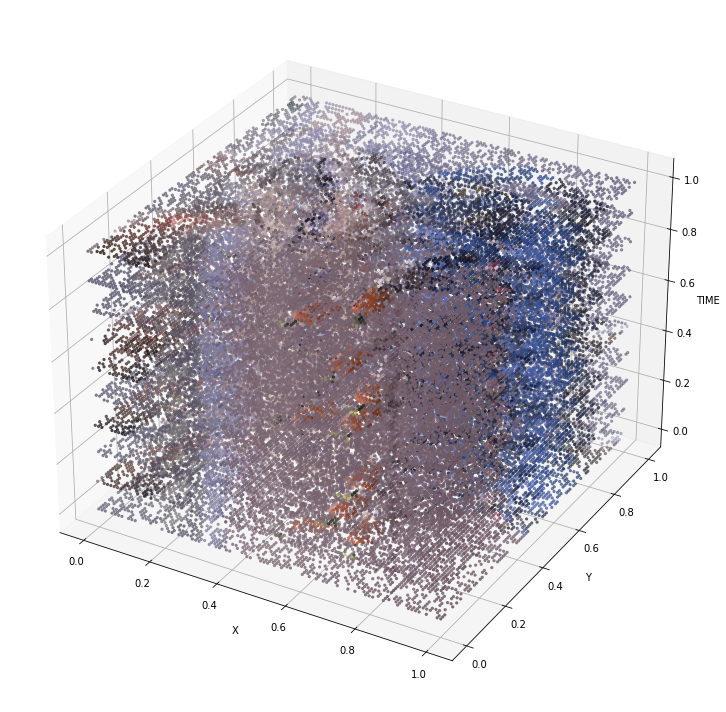

In [5]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

ax.scatter3D(
    pts_time_selected[:,0], 
    pts_time_selected[:,1], 
    pts_time_selected[:,2], 
    c=Y_selected, 
    marker='.')
ax.set_xlabel('X');ax.set_ylabel('Y');ax.set_zlabel('TIME')

plt.tight_layout()
plt.show()

In [6]:
class FreqEncoder(nn.Module):
	r"""
	Sine-cosine positional encoder for input points.
	"""
	def __init__(
		self,
		d_input: int,
		n_freqs: int,
		log_space: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_freqs = n_freqs
		self.log_space = log_space
		self.d_output = d_input * (1 + 2 * self.n_freqs)
		self.embed_fns = [lambda x: x]

		# Define frequencies in either linear or log scale
		if self.log_space:
			freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
		else:
			freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

		# Alternate sin and cos
		for freq in freq_bands:
			self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
			self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

	def forward(
		self,
		x
	) -> torch.Tensor:
		r"""
		Apply positional encoding to input.
		"""
		return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

In [8]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        self.d_output = num_lvl * feature_dim
        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) * 0.0001 + 1e-9
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            floor_corner = torch.floor(coord)  # Find the floor corner for interpolation
            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(self.hashtable[lvl][flat_feature_index],
                                           (corners.shape[0], corners.shape[1], self.feature_dim))
            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            weights = torch.stack([weights]*self.feature_dim, -1)  # Stack weights for each feature
            # Perform weighted interpolation of corner features
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        return torch.cat(out_feature, -1)  # Concatenate features from all levels

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        else:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                  x * minus_y * minus_z,
                                  minus_x * y * minus_z,
                                  x * y * minus_z,
                                  minus_x * minus_y * z,
                                  x * minus_y * z,
                                  minus_x * y * z,
                                  x * y * z], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011], -2)
            return stacks
        else:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            return stacks


In [9]:
class Model(nn.Module):
    def __init__(self, in_dim=2, our_dim=3):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,our_dim)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    

# embedder = FreqEncoder(3,16)
embedder = Grid(
    grid_dim=3, 
    feature_dim=4, 
    num_lvl=8, 
    max_res=1024, 
    min_res=16,
    hashtable_power=10, 
    device=device)


test_x = torch.randn(10,3).to(device)
test_x = embedder(test_x)
print(test_x.shape)

# encoder = Model(test_x.shape[-1], test_x.shape[-1]//4).to(device)

model = Model(test_x.shape[-1]).to(device)

opt = torch.optim.Adam([
    {'params': model.parameters()},
    # {'params': encoder.parameters()},
    {'params': embedder.parameters()},
])

crit = nn.MSELoss()


torch.Size([10, 32])


In [11]:

# def temporal_smoothness_regularization(
#         encoded_vectors, spatial_coordinates, alpha=1.0):
#     # spatial_coordinates is a tensor of shape (N, 2) representing (x, y) for each point

#     # Combine spatial coordinates to form a unique key for each spatial location
#     combined_coords = spatial_coordinates[:, 0] * 10 + spatial_coordinates[:, 1]
#     unique_coords, inverse_indices = torch.unique(combined_coords, return_inverse=True)
    
#     # Compute the variance of encoded vectors for each unique spatial coordinate
#     variances = torch.zeros(unique_coords.size(0), device=encoded_vectors.device)
#     for i in range(unique_coords.size(0)):
#         group_encoded_vectors = encoded_vectors[inverse_indices == i]
#         variances[i] = torch.var(group_encoded_vectors, dim=0).mean()
    
#     # Compute the regularization loss
#     regularization_loss = alpha * variances.mean()
#     return regularization_loss

# # Example usage
# encoded_vectors = torch.tensor([[0.5, 0.1], [0.5, 0.5], [0.5, 0.2]], dtype=torch.float32)
# spatial_coordinates = torch.tensor([[1, 1], [1, 1], [1, 1]], dtype=torch.float32)
# timesteps = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32)  # not used in the new regularization function

# loss = temporal_smoothness_regularization(encoded_vectors, spatial_coordinates)
# print("Regularization Loss:", loss)

In [12]:
results_folder = 'results/2d_xyt2color_selected/'
os.makedirs(results_folder, exist_ok=True)
losses = []

In [20]:
EPOCHS = 1000

pts_time_input = pts_time_selected.to(device)
Y_selected = Y_selected.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    # Shuffle
    shuffle_idx = torch.randperm(N_samples)
    shuffled_pts_time_input = pts_time_input[shuffle_idx]
    pts_time_enc = embedder(shuffled_pts_time_input)

    # REGULARIZATION
    points = shuffled_pts_time_input[:,:2] + shuffled_pts_time_input[:,:2] *7
    u_points, inverse = torch.unique(points, return_inverse=True)

    variances = torch.zeros(u_points.shape[0], device=device)
    for i in range(u_points.shape[0]):
        group = pts_time_enc[inverse==i]
        variances[i] = torch.var(group, dim=0).mean()
    reg_loss = variances.mean() * 0.01
    ##

    predictions = model(pts_time_enc)


    loss = crit(predictions, Y_selected[shuffle_idx]) + reg_loss
    loss.backward()
    opt.step()

    # Logging

    losses+= [loss.item()]
    

100%|██████████| 1000/1000 [00:14<00:00, 69.17it/s]


In [31]:
torch.var(pts_time_enc[[0,1,3]], 0).mean()

tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>)

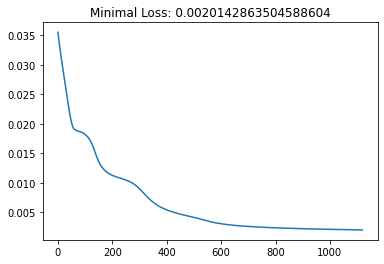

In [21]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')
plt.show()

In [22]:
pts_time_enc = pts_time.to(device)
pts_time_enc = embedder(pts_time_enc)
with torch.no_grad():
    # hidden = encoder(pts_time_enc)
    predictions = model(pts_time_enc)
    predictions = predictions.detach().cpu()


Predicted_images shape: torch.Size([100, 100, 10, 3])


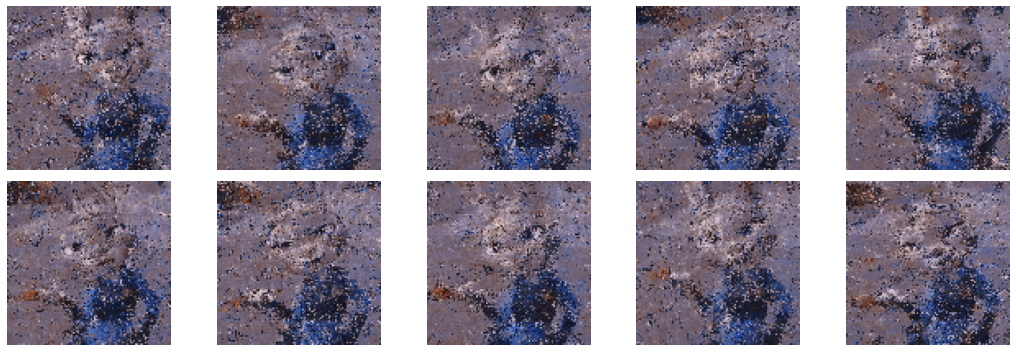

In [23]:
predicted_images = predictions.reshape(*RESOLUTION,3)
print('Predicted_images shape:',predicted_images.shape)

fig,ax = plt.subplots(2,5, figsize=(15,5))
k=0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(predicted_images[:,:,k])
        ax[i,j].axis('off')
        k+=1

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(predicted_images[:,:,0])

# 3D + time

In [ ]:
RESOLUTION = [100,100,4] # (H,W,videos)
TIMESTEPS = 7

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])
z = np.linspace(0,1,RESOLUTION[2])

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')


pts = np.array([xx.reshape(-1), yy.reshape(-1),zz.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[5:15], pts.shape

In [ ]:
path = '../data/4d_test_data'

names = sorted([x for x in os.listdir(path) if '.png' in x])

# load one set
def load_one_set(names, prefix='0_'):

    _names = [x for x in names if prefix in x]
    images = []
    for i in range(len(_names)):
        im_path = os.path.join(path, _names[i])
        im = Image.open(im_path).convert('RGB').resize((RESOLUTION[0],RESOLUTION[1]))
        im = torch.tensor(np.array(im)).reshape((RESOLUTION[0],RESOLUTION[1],3,1)) / 255
        images += [im]

    images = torch.cat(images, -1)
    # print(images.shape)
    return images
imgs0 = load_one_set(names, '0_')
imgs1 = load_one_set(names, '1_')
imgs2 = load_one_set(names, '2_')
imgs3 = load_one_set(names, '3_')

In [ ]:
timesteps = []
Y = []
for t in range(TIMESTEPS):
    imgs_at_t = [
        imgs0[:,:,:,t].unsqueeze(-2),
        imgs1[:,:,:,t].unsqueeze(-2),
        imgs2[:,:,:,t].unsqueeze(-2),
        imgs3[:,:,:,t].unsqueeze(-2),
        ]
    
    imgs_at_t = torch.cat(imgs_at_t,-2)
    # print(imgs_at_t.shape)
    imgs_at_t = imgs_at_t.reshape(-1,3)
    # print(imgs_at_t.shape)

    Y += [imgs_at_t.unsqueeze(0)]

    # timesteps += [torch.zeros(imgs_at_t.shape[0],1) + t]
    timesteps += [torch.zeros(1) + t]

    # ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    # ax.scatter3D(pts[:,0], pts[:,1], pts[:,2], c=imgs_at_t)
    # ax.set_title(f'TIMESTEP {t}')

timesteps = torch.cat(timesteps,-1) / np.max(timesteps)
Y = torch.cat(Y)


In [ ]:
pts.shape,timesteps, Y.shape

In [ ]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'
                 ):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        self.d_output = num_lvl * grid_dim

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861, 9322189897]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) *0.001 #* 0.0001 #+ torch.rand(1).to(self.device)
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        # Normalization
        # _min = torch.tensor([-3.5552, -2.1935, -2.8307]).to(self.device)
        # _max = torch.tensor([1.8859, 3.1777, 2.0705]).to(self.device)
        # x = (x - _min ) / (_max - _min)

        # print(x.min(0)[0], x.max(0)[0])
        
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            # Find the floor corner for interpolation
            floor_corner = torch.floor(coord)  
            

            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            

            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            

            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(
                self.hashtable[lvl][flat_feature_index],
                (corners.shape[0], corners.shape[1], self.feature_dim))
            

            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            
            
            # Stack weights for each feature
            if self.grid_dim == 2:
                weights = torch.stack([weights, weights], -1)  
            elif self.grid_dim == 3:
                weights = torch.stack([weights, weights, weights], -1)  
            elif self.grid_dim == 4:
                weights = torch.stack([weights, weights, weights, weights], -1)  
            

            # Perform weighted interpolation of corner features
            
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        outs = torch.cat(out_feature, -1)  # Concatenate features from all levels
        # debug('Hash (max:min) check: '+str(outs.max().item())+' : '+str(outs.min().item()))
        return outs

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        elif self.grid_dim == 3:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                x * minus_y * minus_z,
                                minus_x * y * minus_z,
                                x * y * minus_z,
                                minus_x * minus_y * z,
                                x * minus_y * z,
                                minus_x * y * z,
                                x * y * z], -1)
            return stacks
        elif self.grid_dim == 4:
            # For 4D, calculate weights for the sixteen corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            minus_w = (ones - diff)[..., 3]  # Calculate 1 - w for each dimension
            w = diff[..., 3]  # Get the w difference
            stacks = torch.stack([minus_x * minus_y * minus_z * minus_w,
                                x * minus_y * minus_z * minus_w,
                                minus_x * y * minus_z * minus_w,
                                x * y * minus_z * minus_w,
                                minus_x * minus_y * z * minus_w,
                                x * minus_y * z * minus_w,
                                minus_x * y * z * minus_w,
                                x * y * z * minus_w,
                                minus_x * minus_y * minus_z * w,
                                x * minus_y * minus_z * w,
                                minus_x * y * minus_z * w,
                                x * y * minus_z * w,
                                minus_x * minus_y * z * w,
                                x * minus_y * z * w,
                                minus_x * y * z * w,
                                x * y * z * w], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([c000, c010, c001, c011], -2)
            
            return stacks
        elif self.grid_dim == 3:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            
            return stacks
        elif self.grid_dim == 4:
            # Calculate corners for 4D grids
            c0000 = floor_corner
            c0001 = floor_corner + torch.tensor([0, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c0010 = floor_corner + torch.tensor([0, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c0011 = floor_corner + torch.tensor([0, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c0100 = floor_corner + torch.tensor([0, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c0101 = floor_corner + torch.tensor([0, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c0110 = floor_corner + torch.tensor([0, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c0111 = floor_corner + torch.tensor([0, 1, 1, 1], device=self.device).repeat(num_entry, 1)
            c1000 = floor_corner + torch.tensor([1, 0, 0, 0], device=self.device).repeat(num_entry, 1)
            c1001 = floor_corner + torch.tensor([1, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c1010 = floor_corner + torch.tensor([1, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c1011 = floor_corner + torch.tensor([1, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c1100 = floor_corner + torch.tensor([1, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c1101 = floor_corner + torch.tensor([1, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c1110 = floor_corner + torch.tensor([1, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c1111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([
                c0000, c0001, c0010, c0011, c0100, c0101, c0110, c0111, 
                c1000, c1001, c1010, c1011, c1100, c1101, c1110, c1111], -2)
            
            return stacks



In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    


grid = Grid(
    feature_dim=4, 
    grid_dim=4, 
    num_lvl=8, 
    max_res=1024, 
    min_res=16,
    hashtable_power=19, 
    device=device)

test_out = grid(torch.randn(10,4).to(device))
print(test_out.shape)
model = Model(test_out.shape[-1]).to(device)

# test_x = grid(pts_time.to(device))
# print(test_x.shape)
# model = Model(test_x.shape[-1]).to(device)

opt = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': grid.parameters()},
])

crit = nn.MSELoss()


In [ ]:
results_folder = 'results/3d_xyzt2color/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
# pts_time = pts_time.to(device)
# timesteps = timesteps.to(device)
# Y = Y.to(device)
k = -1
for epoch in tqdm(range(EPOCHS)):
    k+=1
    opt.zero_grad()

    if k >= TIMESTEPS:
        k = 0

    idx = k #torch.randint(low=0, high=TIMESTEPS, size=(1,))
    _time = torch.zeros(pts.shape[0], 1) + timesteps[idx]
    pts_time = torch.cat([pts, _time], -1).to(device)
    enc_pts = grid(pts_time)

    _Y = Y[idx].to(device)

    # enc_pts = grid(pts_time)

    predictions = model(enc_pts)

    loss = crit(predictions, _Y)
    loss.backward()
    opt.step()

    # Logging
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    pred_img = get_3d_image_height(predictions, RESOLUTION)
    pred_img.save(ph)

    losses+= [loss.item()]
    # for i in range(1000):
        

In [ ]:
# for i in range(4):
#     _im = predictions.reshape(100,100,4,3)[:,:,i]
#     _im = np.array(_im.detach().cpu() * 255).astype(np.uint8)
#     Image.fromarray(_im)


In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
out_path = '../xyzt2rgb_animation.gif'
make_a_gif(results_folder, out_path, img_size='200:200:-1')

# 3D + time, randomly sampled data

In [ ]:
RESOLUTION = [100,100,4] # (H,W,videos)
TIMESTEPS = 7

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])
z = np.linspace(0,1,RESOLUTION[2])

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')


pts = np.array([xx.reshape(-1), yy.reshape(-1),zz.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[5:15], pts.shape

In [ ]:
path = '../data/4d_test_data'

names = sorted([x for x in os.listdir(path) if '.png' in x])

# load one set
def load_one_set(names, prefix='0_'):

    _names = [x for x in names if prefix in x]
    images = []
    for i in range(len(_names)):
        im_path = os.path.join(path, _names[i])
        im = Image.open(im_path).convert('RGB').resize((RESOLUTION[0],RESOLUTION[1]))
        im = torch.tensor(np.array(im)).reshape((RESOLUTION[0],RESOLUTION[1],3,1)) / 255
        images += [im]

    images = torch.cat(images, -1)
    # print(images.shape)
    return images
imgs0 = load_one_set(names, '0_')
imgs1 = load_one_set(names, '1_')
imgs2 = load_one_set(names, '2_')
imgs3 = load_one_set(names, '3_')

In [ ]:
timesteps = []
Y = []
for t in range(TIMESTEPS):
    imgs_at_t = [
        imgs0[:,:,:,t].unsqueeze(-2),
        imgs1[:,:,:,t].unsqueeze(-2),
        imgs2[:,:,:,t].unsqueeze(-2),
        imgs3[:,:,:,t].unsqueeze(-2),
        ]
    
    imgs_at_t = torch.cat(imgs_at_t,-2)
    # print(imgs_at_t.shape)
    imgs_at_t = imgs_at_t.reshape(-1,3)
    # print(imgs_at_t.shape)

    Y += [imgs_at_t.unsqueeze(0)]

    # timesteps += [torch.zeros(imgs_at_t.shape[0],1) + t]
    timesteps += [torch.zeros(1) + t]

    # ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    # ax.scatter3D(pts[:,0], pts[:,1], pts[:,2], c=imgs_at_t)
    # ax.set_title(f'TIMESTEP {t}')

timesteps = torch.cat(timesteps,-1) / np.max(timesteps)
Y = torch.cat(Y)


In [ ]:
# Sample data
torch.manual_seed(2024)
N_SAMPLE = 10000

data = {
    'points':[],
    'timesteps':[],
    'rgb':[],
}

for t in range(TIMESTEPS): # For each timestep sample N points
    idxs = torch.randperm(pts.shape[0])[:N_SAMPLE]

    _pts = pts[idxs]
    _time = timesteps[t]
    _rgb = Y[t,idxs]

    data['points']      += [_pts]
    data['timesteps']   += [_time]
    data['rgb']         += [_rgb]

data['timesteps']

In [ ]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'
                 ):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        self.d_output = num_lvl * feature_dim

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861, 9322189897]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) *0.001 #* 0.0001 #+ torch.rand(1).to(self.device)
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        # Normalization
        # _min = torch.tensor([-3.5552, -2.1935, -2.8307]).to(self.device)
        # _max = torch.tensor([1.8859, 3.1777, 2.0705]).to(self.device)
        # x = (x - _min ) / (_max - _min)

        # print(x.min(0)[0], x.max(0)[0])
        
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            # Find the floor corner for interpolation
            floor_corner = torch.floor(coord)  
            

            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            

            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            

            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(
                self.hashtable[lvl][flat_feature_index],
                (corners.shape[0], corners.shape[1], self.feature_dim))
            

            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            
            
            # Stack weights for each feature
            weights = torch.stack([weights]*self.feature_dim, -1)
            # if self.grid_dim == 2:
            #     weights = torch.stack([weights, weights], -1)  
            # elif self.grid_dim == 3:
            #     weights = torch.stack([weights, weights, weights], -1)  
            # elif self.grid_dim == 4:
            #     weights = torch.stack([weights, weights, weights, weights], -1)  
            

            # Perform weighted interpolation of corner features
            
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        outs = torch.cat(out_feature, -1)  # Concatenate features from all levels
        # debug('Hash (max:min) check: '+str(outs.max().item())+' : '+str(outs.min().item()))
        return outs

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        elif self.grid_dim == 3:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                x * minus_y * minus_z,
                                minus_x * y * minus_z,
                                x * y * minus_z,
                                minus_x * minus_y * z,
                                x * minus_y * z,
                                minus_x * y * z,
                                x * y * z], -1)
            return stacks
        elif self.grid_dim == 4:
            # For 4D, calculate weights for the sixteen corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            minus_w = (ones - diff)[..., 3]  # Calculate 1 - w for each dimension
            w = diff[..., 3]  # Get the w difference
            stacks = torch.stack([minus_x * minus_y * minus_z * minus_w,
                                x * minus_y * minus_z * minus_w,
                                minus_x * y * minus_z * minus_w,
                                x * y * minus_z * minus_w,
                                minus_x * minus_y * z * minus_w,
                                x * minus_y * z * minus_w,
                                minus_x * y * z * minus_w,
                                x * y * z * minus_w,
                                minus_x * minus_y * minus_z * w,
                                x * minus_y * minus_z * w,
                                minus_x * y * minus_z * w,
                                x * y * minus_z * w,
                                minus_x * minus_y * z * w,
                                x * minus_y * z * w,
                                minus_x * y * z * w,
                                x * y * z * w], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([c000, c010, c001, c011], -2)
            
            return stacks
        elif self.grid_dim == 3:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            
            return stacks
        elif self.grid_dim == 4:
            # Calculate corners for 4D grids
            c0000 = floor_corner
            c0001 = floor_corner + torch.tensor([0, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c0010 = floor_corner + torch.tensor([0, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c0011 = floor_corner + torch.tensor([0, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c0100 = floor_corner + torch.tensor([0, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c0101 = floor_corner + torch.tensor([0, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c0110 = floor_corner + torch.tensor([0, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c0111 = floor_corner + torch.tensor([0, 1, 1, 1], device=self.device).repeat(num_entry, 1)
            c1000 = floor_corner + torch.tensor([1, 0, 0, 0], device=self.device).repeat(num_entry, 1)
            c1001 = floor_corner + torch.tensor([1, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c1010 = floor_corner + torch.tensor([1, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c1011 = floor_corner + torch.tensor([1, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c1100 = floor_corner + torch.tensor([1, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c1101 = floor_corner + torch.tensor([1, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c1110 = floor_corner + torch.tensor([1, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c1111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            
            stacks = torch.stack([
                c0000, c0001, c0010, c0011, c0100, c0101, c0110, c0111, 
                c1000, c1001, c1010, c1011, c1100, c1101, c1110, c1111], -2)
            
            return stacks



In [ ]:
# class Model(nn.Module):
#     def __init__(self, in_dim=2):
#         super().__init__()
#         self.f1 = nn.Linear(in_dim,32)
#         self.f2 = nn.Linear(32,32)
#         self.f3 = nn.Linear(32,32)
#         self.f4 = nn.Linear(32,3)
#         self.act = nn.ReLU()
#         self.s = nn.Sigmoid()
#     def forward(self,x):
#         x = self.f1(x)
#         x = self.act(x)
#         x = self.f2(x)
#         x = self.act(x)
#         x = self.f3(x)
#         x = self.act(x)
#         x = self.f4(x)
#         x = self.s(x)
#         return x
    
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        # self.sigma = nn.Linear(32,3)
        self.act = nn.LeakyReLU()
        self.s = nn.Sigmoid()

        self.log_var = torch.tensor(0.001)
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    


grid = Grid(
    grid_dim=3, 
    feature_dim=4, 
    num_lvl=8, 
    max_res=1024, 
    min_res=16,
    hashtable_power=19, 
    device=device)

test_out = grid(torch.randn(10,3).to(device))
print(test_out.shape)
model = Model(test_out.shape[-1]).to(device)
model(test_out)


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(4, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 3)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
dnerf = SimpleNN()


opt = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': grid.parameters()},
    {'params': dnerf.parameters()},

])

crit = nn.MSELoss()


In [ ]:
results_folder = 'results/3d_xyzt2color_sampled/'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
EPOCHS = 1000
losses = []
# pts_time = pts_time.to(device)
# timesteps = timesteps.to(device)
# Y = Y.to(device)
k = -1
for epoch in tqdm(range(EPOCHS)):
    k+=1
    opt.zero_grad()

    if k >= TIMESTEPS:
        k = 0

    idx = k #torch.randint(low=0, high=TIMESTEPS, size=(1,))
    _pts = data['points'][idx]
    _timestep = data['timesteps'][idx] 
    _time = torch.zeros(_pts.shape[0], 1) + _timestep 
    pts_time = torch.cat([_pts, _time], -1).to(device)
    dx = dnerf(_time)
    _pts = _pts + dx

    enc_pts = grid(_pts)

    _Y = data['rgb'][idx].to(device)

    # enc_pts = grid(pts_time)

    predictions = model(enc_pts)

    loss = crit(predictions, _Y)
    loss.backward()
    opt.step()

    # Logging
    # ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    # pred_img = get_3d_image_height(predictions, RESOLUTION)
    # pred_img.save(ph)

    losses+= [loss.item()]
    # for i in range(1000):
        

In [ ]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [ ]:
for t in range(TIMESTEPS):
    _pts = pts
    _timestep = data['timesteps'][t]
    _time = torch.zeros(_pts.shape[0], 1) + _timestep
    pts_time = torch.cat([_pts, _time], -1).to(device)

    with torch.no_grad():
        model.eval()
        enc_pts = grid(pts_time)
        predictions = model(enc_pts)

        pred = predictions.reshape(*RESOLUTION,3).detach().cpu()

    fig, ax = plt.subplots(2,2, figsize=(5,5))
    fig.suptitle(f'Timestep {t}')
    ax[0,0].imshow(pred[:,:,0])
    ax[0,1].imshow(pred[:,:,1])
    ax[1,0].imshow(pred[:,:,2])
    ax[1,1].imshow(pred[:,:,3])
    plt.show()


